In [28]:
print("Hello World!")

Hello World!


In [29]:
import os
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
class StrawberryDiseaseClassifier:
    def __init__(self, data_dir="../data/strawberry", img_size=224):
        """
        Trains a disease detection model for strawberries.
        Searches for train/valid/test subfolders in data_dir.
        Each .jpg has a corresponding .json containing 'shapes'[0]['label'].
        """
        self.data_dir = data_dir
        self.img_size = img_size
        self.model = None
        
        #label->index mapping (unqiue classes in STRAWBERRY dataset)
        all_labels = self.collect_labels()
        self.labels = sorted(list(all_labels))
        self.label2idx = {label: i for i, label in enumerate(self.labels)}
        
        self.X_train, self.y_train = self.load_data(os.path.join(data_dir, "train"))
        self.X_valid, self.y_valid = self.load_data(os.path.join(data_dir, "valid"))
        self.X_test,  self.y_test  = self.load_data(os.path.join(data_dir, "test"))

        num_classes = len(self.labels)

        #ResNet50 base model
        base_model = ResNet50(weights="imagenet", include_top=False,
                              input_shape=(img_size, img_size, 3))
        base_model.trainable = False  #freeze base layers

        x = layers.GlobalAveragePooling2D()(base_model.output)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)
        self.model = models.Model(inputs=base_model.input, outputs=outputs)

        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-4),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
        print(self.model.summary())
    
    def collect_labels(self):
        """Collect all labels from train, valid, and test folders to build a single label map."""
        label_set = set()
        for folder in ["train", "valid", "test"]:
            folder_path = os.path.join(self.data_dir, folder)
            if not os.path.exists(folder_path):
                continue
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(".json"):
                    json_path = os.path.join(folder_path, filename)
                    with open(json_path, "r") as f:
                        data = json.load(f)
                    #label from shapes[0]['label']
                    if data.get("shapes"):
                        label_str = data["shapes"][0].get("label", None)
                        if label_str:
                            label_set.add(label_str)
        return label_set

    def load_data(self, folder_path):
        """
        Loads images and labels from a folder (and their JSON files) into NumPy arrays (X, y).
        Assumes JSON structure with shapes[0]['label'] as the disease.
        """
        images_data = []
        labels_data = []

        if not os.path.exists(folder_path):
            return np.array([]), np.array([])
        
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(".jpg"):
                img_path = os.path.join(folder_path, filename)
                json_path = img_path.replace(".jpg", ".json")

                if not os.path.exists(json_path):
                    continue
                
                with open(json_path, "r") as f:
                    info = json.load(f)
                
                if not info.get("shapes"):
                    continue
                label_str = info["shapes"][0].get("label", None)
                if label_str not in self.label2idx:
                    continue
                label_idx = self.label2idx[label_str]

                # Load and preprocess image
                img = load_img(img_path, target_size=(self.img_size, self.img_size))
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)

                images_data.append(img_array)
                labels_data.append(label_idx)
        
        X = np.array(images_data)
        #one-hot vector conversion
        y = to_categorical(np.array(labels_data), num_classes=len(self.labels))
        return X, y

    def train(self, epochs=10):
        """
        Train the model on the loaded dataset.
        """
        if self.X_train.size == 0:
            print("No training data found.")
            return None
        
        history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_valid, self.y_valid),
            epochs=epochs,
            batch_size=32
        )
        return history

    def evaluate(self):
        """
        Evaluate on the test set with additional performance metrics.
        """
        if self.X_test.size == 0:
            print("No test data found.")
            return None
        
        #model accuracy and loss
        loss, accuracy = self.model.evaluate(self.X_test, self.y_test, verbose=0)
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Loss: {loss:.4f}")

        #classification report + confusion matrix
        y_pred_probs = self.model.predict(self.X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(self.y_test, axis=1)
        
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=self.labels))
        
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.labels, yticklabels=self.labels)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        
        return accuracy

    def predict_image(self, image_path):
        """
        Predict the disease class for a single image.
        """
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return None
        
        img = load_img(image_path, target_size=(self.img_size, self.img_size))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        predictions = self.model.predict(img_array)[0]
        top_indices = predictions.argsort()[-4:][::-1]
        top_predictions = [(self.labels[i], float(predictions[i])) for i in top_indices]

        result = {
            "top_predictions": top_predictions,
            "all_probabilities": {
                self.labels[i]: float(prob) for i, prob in enumerate(predictions)
            },
        }
        return result

    def save_model(self, filename="strawberry_disease_classifier.h5"):
        """
        Save model to disk.
        """
        if self.model:
            os.makedirs("models", exist_ok=True)
            path = os.path.join("models", filename)
            self.model.save(path)
            print(f"Model saved to {path}")

In [31]:
classifier = StrawberryDiseaseClassifier()
classifier.train(epochs=25)

#example of classifying custom input image
#classifier.predict_image("../data/strawberry/test/some_image.jpg")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,610,247 (90.07 MB)

 Trainable params: 18,439 (72.03 KB)

 Non-trainable params: 23,591,808 (90.00 MB)

None
Epoch 1/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 684ms/step - accuracy: 0.2101 - loss: 2.7391 - val_accuracy: 0.4169 - val_loss: 1.5024
Epoch 2/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 634ms/step - accuracy: 0.5027 - loss: 1.5447 - val_accuracy: 0.7362 - val_loss: 0.9367
Epoch 3/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 642ms/step - accuracy: 0.6893 - loss: 0.9969 - val_accuracy: 0.8469 - val_loss: 0.6393
Epoch 4/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 663ms/step - accuracy: 0.7498 - loss: 0.7636 - val_accuracy: 0.8860 - val_loss: 0.4724
Epoch 5/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 679ms/step - accuracy: 0.7835 - loss: 0.6323 - val_accuracy: 0.9153 - val_loss: 0.3710
Epoch 6/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 647ms/step - accuracy: 0.8016 - loss: 0.5688 - val_accuracy: 0.9283 - val_loss: 0.3138
Epoch 7/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 706ms/step - accuracy: 0.8437 - loss: 0.4808 - val_accuracy: 0.9316 - val_loss: 0.2800
Epoch 8/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 32s 689ms/step - accuracy: 0.8753 - loss: 0.4172 - val

Test Accuracy: 0.8600
Test Loss: 0.4364
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step

Classification Report:
                       precision    recall  f1-score   support

     Angular Leafspot       0.82      0.96      0.88       147
Anthracnose Fruit Rot       0.68      0.74      0.70        34
       Blossom Blight       0.98      1.00      0.99        62
            Gray Mold       0.80      0.97      0.87       145
            Leaf Spot       0.98      0.70      0.81       161
 Powdery Mildew Fruit       0.63      0.28      0.39        43
  Powdery Mildew Leaf       0.91      0.97      0.94       151

             accuracy                           0.86       743
            macro avg       0.83      0.80      0.80       743
         weighted avg       0.86      0.86      0.85       743



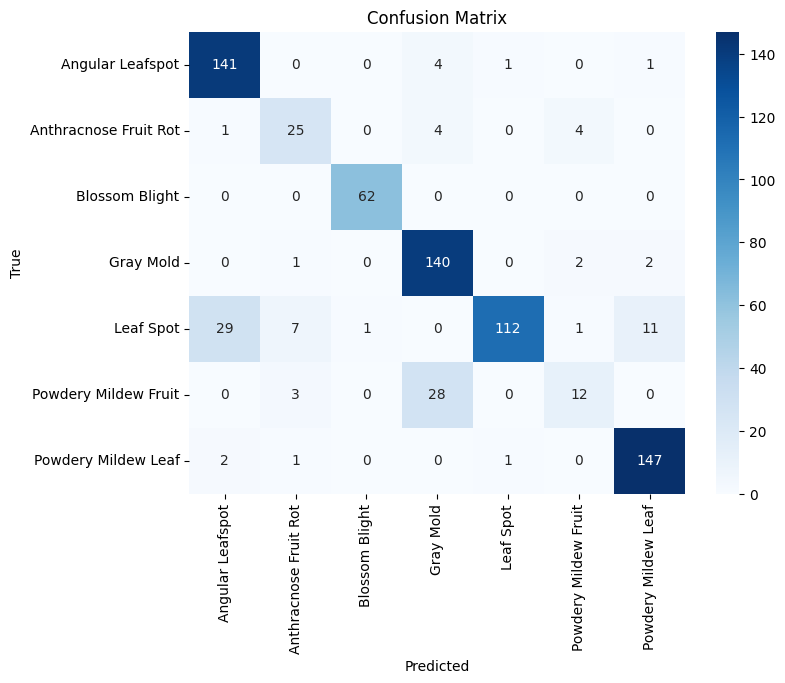

0.8600268959999084

In [32]:
classifier.evaluate()

In [33]:
classifier.save_model()

Model saved to models/strawberry_disease_classifier.h5
